# 単回帰分析

## 準備

### データの読み込み

『家計調査』2017年11月、第2−6表「年間収入階級別1世帯当たり1か月間の収入と支出」から作成した所得階級と支出のデータ`kakei201709_l18.csv`を用いる\[^url\].

月間消費支出(円)(`CONS`), 月間消費支出(1万円)(`CONS1`),
年間収入(1万円)(INC), 有業人員(人)(`WORK`). いずれも調査世帯の平均値/

In [ ]:
library(pacman)
p_load(readr, here)
kakei <- readr::read_csv(here("data", "kakei201709_l18.csv"))

Rows: 18 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): CONS, CONS1, INC, WORK

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

[1] "CONS"  "CONS1" "INC"   "WORK" 

### データ構造の把握

データを読み込んだらどのようなデータで構成されているのか確認を行う.
`dplyr`パッケージの`glimpse`関数を利用する.

In [ ]:
p_load(dplyr)
dplyr::glimpse(kakei)

Rows: 18
Columns: 4
$ CONS  <dbl> 136729, 183383, 188091, 220990, 233309, 242098, 244986, 254604, …
$ CONS1 <dbl> 13.6729, 18.3383, 18.8091, 22.0990, 23.3309, 24.2098, 24.4986, 2…
$ INC   <dbl> 154, 226, 275, 322, 372, 422, 473, 521, 573, 622, 672, 720, 771,…
$ WORK  <dbl> 0.49, 0.68, 0.59, 0.68, 0.85, 1.12, 1.31, 1.45, 1.50, 1.72, 1.70…

### 記述統計の確認

データ構造を確認したら, 次に記述統計を確認する. 記述統計を把握するには,
`summary`を利用する.

In [ ]:
summary(kakei)

      CONS            CONS1            INC              WORK       
 Min.   :136729   Min.   :13.67   Min.   : 154.0   Min.   :0.4900  
 1st Qu.:235506   1st Qu.:23.55   1st Qu.: 384.5   1st Qu.:0.9175  
 Median :281254   Median :28.13   Median : 597.5   Median :1.6000  
 Mean   :291127   Mean   :29.11   Mean   : 688.7   Mean   :1.4150  
 3rd Qu.:316269   3rd Qu.:31.63   3rd Qu.: 825.0   3rd Qu.:1.8275  
 Max.   :551735   Max.   :55.17   Max.   :2034.0   Max.   :2.1400  

### ヒストグラムの描画

記述統計を把握したら, ヒストグラムを描いてデータをグラフで確認する.
`ggplot2`パッケージをの`geom_histogram()`関数を使ってヒストグラムを描く.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

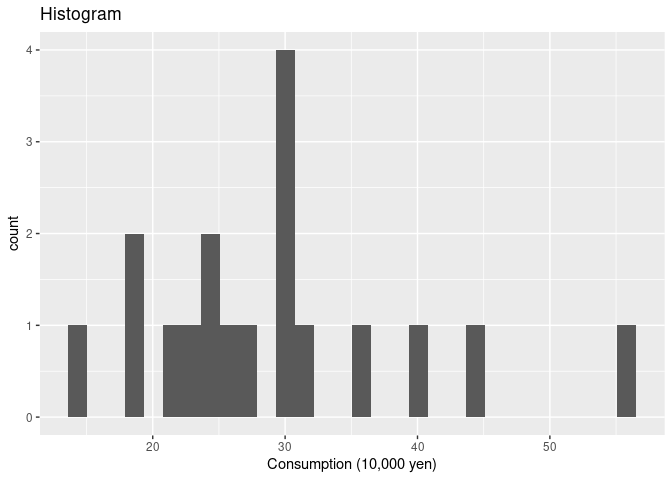

In [ ]:
p_load(ggplot2)
ggplot(data = kakei) +
  aes(x = CONS1) +
  geom_histogram() +
  xlab("Consumption (10,000 yen)") +
  ggtitle("Histogram")

## 相関関係

### 散布図の描画

2変数間の関係を把握するために散布図を描くには,
`geom_point()`関数を利用する.

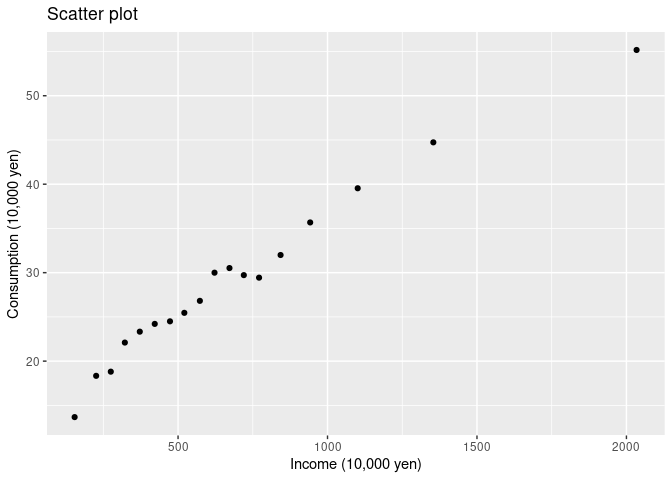

In [ ]:
ggplot(data = kakei) +
  aes(x = INC,
      y = CONS1) +
  geom_point() + 
  xlab("Income (10,000 yen)") + 
  ylab("Consumption (10,000 yen)") +
  ggtitle("Scatter plot")

### ピアソンの積率相関係数の算出

ピアソンの積率相関係数を算出するためには, `cor.test()`関数を利用する.

In [ ]:
cor.test(x      = kakei$INC,
         y      = kakei$CONS1,
         method = "pearson")


    Pearson's product-moment correlation

data:  kakei$INC and kakei$CONS1
t = 24.168, df = 16, p-value = 5.075e-14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9635024 0.9951013
sample estimates:
      cor 
0.9865791 

### シミュレーションデータと散布図(Advanced)

相関係数を自身で決めてグラフを描いてみる.
まずは相関係数0.9の散布図を描く.
ある相関係数に従う乱数を生成するには`MASS`パッケージの`mvnorm()`関数を用いる.

`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.

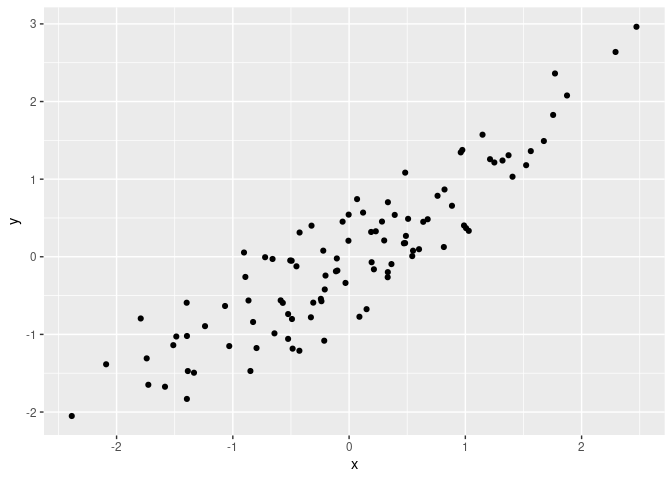

In [ ]:
p_load(withr, MASS, tibble)
with_seed(
  2718,
  mvrnorm(n     = 100,
          mu    = c(0, 0), 
          Sigma = matrix(c(1,   0.9, 
                           0.9, 1),
                         ncol = 2),
          empirical = TRUE)) |> 
  as_tibble() |> 
  dplyr::rename(x = 1, 
                y = 2) |>
  ggplot() +
  aes(x = x, 
      y = y) +
  geom_point()

### 様々な相関係数と散布図(Advanced)

`purrr`パッケージを用いて様々な相関係数の散布図を描画する.

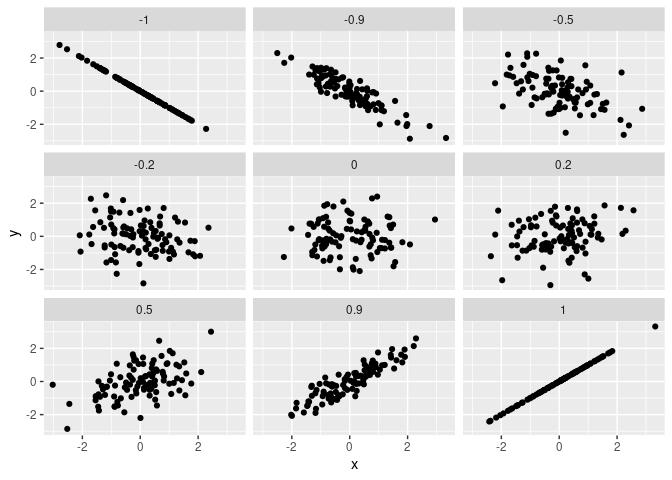

In [ ]:
p_load(purrr)
list <- list(-1, -0.9, -0.5, -0.2, 0, 
             0.2, 0.5, 0.9,  1)
with_seed(
  2718,
  list |>
    map(
      \(x) mvrnorm(
        n         = 100,
        mu        = c(0, 0),
        Sigma     = matrix(c(1, x, x, 1),
                           ncol = 2),
        empirical = TRUE))) |>
  map(as_tibble) |> 
  purrr::set_names(list) |> 
  map(\(data) rename(data, x = 1, y = 2)) |> 
  list_rbind(names_to = "cor") |> 
  mutate(cor = as.numeric(cor) |> 
           as.factor()) |> 
  ggplot() +
  aes(x = x,
      y = y) +
  geom_point() +
  facet_wrap(~ cor)

### 相関のないデータ

次のデータの2変数は関係のある変数だろうかない変数だろうか. なお,
`cor.test()`関数は次のように書くこともできる.

In [ ]:
cor_data <- read_csv(here("data", "cor.csv"))

Rows: 200 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


    Pearson's product-moment correlation

data:  x and y
t = 0.71547, df = 198, p-value = 0.4752
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.08858416  0.18819606
sample estimates:
       cor 
0.05078096 

### 関係はあるが相関のないデータ

相関係数はあくまで直線関係しか判断できない.

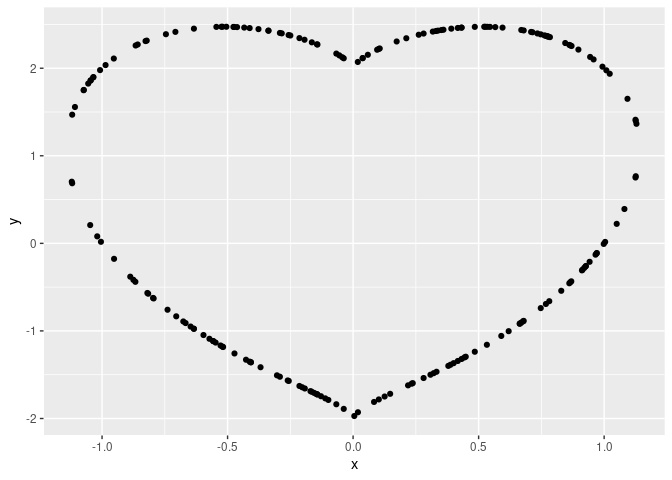

In [ ]:
ggplot(data = cor_data) +
  aes(x = x, 
      y = y) +
  geom_point()

## 単回帰分析の実行

### 単回帰分析

最小二乗法を用いて単回帰分析を行うためには, `lm()`関数を利用する.
第1引数に分析のモデルを指定する. `~`の前に応答変数を,
`~`の後に説明変数を指定する.

In [ ]:
ols1 <- lm(CONS1 ~ INC, data = kakei)

### 結果の示し方

`summary()`関数で結果を見るのが一般的だが,
`jtools`パッケージの`summ()`関数や`stargazer`パッケージの`stargazer()`関数などを使うほうが良い.
`jtools`パッケージは自分が結果を見るときに使うのがおすすめ.
`stargazer`パッケージは結果をそのまま論文などに転載したいときにおすすめ.

In [ ]:
p_load(jtools)
jtools::summ(ols1)

MODEL INFO:
Observations: 18
Dependent Variable: CONS1
Type: OLS linear regression 

MODEL FIT:
F(1,16) = 584.11, p = 0.00
R² = 0.97
Adj. R² = 0.97 

Standard errors:OLS
------------------------------------------------
                     Est.   S.E.   t val.      p
----------------- ------- ------ -------- ------
(Intercept)         14.35   0.73    19.71   0.00
INC                  0.02   0.00    24.17   0.00
------------------------------------------------

### 結果の読み方

MODEL INFOにモデルの内容が記述される. Observationsにサンプルサイズが,
Dependent Variableに応答変数が, Typeに分析方法が示される.
今回はサンプルサイズ18で, 応答変数は`CONS1`,
分析方法は最小二乗法(OLS)であることが示される.

MODEL FITに分析の結果が記述される. 回帰式の適合度検定のF値がまず示され,
p値が計算されている. 次に決定係数$R^2$の値が示され,
その下に自由度調整済み決定係数$adj. R^2$が示される.

最後の表に分析の結果が示される. (Intercept)に定数項が,
その後に説明変数が示される. Est. の列に回帰係数が, S.E.
に標準誤差が示される. t val.にt値が示され, pにp値が示される.

### 結果を論文に掲載する

結果を論文に掲載できるようにきれいに整形するには`stargazer`パッケージを利用するのが便利.
様々な引数があるので, 使いこなすにはHELPを参照のこと.

`star.cutoffs = NA, omit.table.layout = "n"`は忘れない.
分析がしたいのであって, 天体観測がしたいわけではないことに注意.

In [ ]:
p_load(stargazer)
stargazer::stargazer(ols1,
                     type              = "text",
                     style             = "all", 
                     ci                = TRUE,
                     star.cutoffs      = NA, 
                     omit.table.layout = 'n',
                     align             = TRUE)


                          Dependent variable:       
                    --------------------------------
                                 CONS1              
----------------------------------------------------
INC                              0.021              
                             (0.020, 0.023)         
                               t = 24.168           
                               p = 0.000            
Constant                         14.350             
                            (12.923, 15.777)        
                               t = 19.713           
                               p = 0.000            
----------------------------------------------------
Observations                       18               
R2                               0.973              
Adjusted R2                      0.972              
Residual Std. Error         1.680 (df = 16)         
F Statistic         584.114 (df = 1; 16) (p = 0.000)

### 散布図と回帰直線

散布図に回帰直線を引きたい場合には, `geom_smooth()`関数を利用する.

`geom_smooth()` using formula = 'y ~ x'

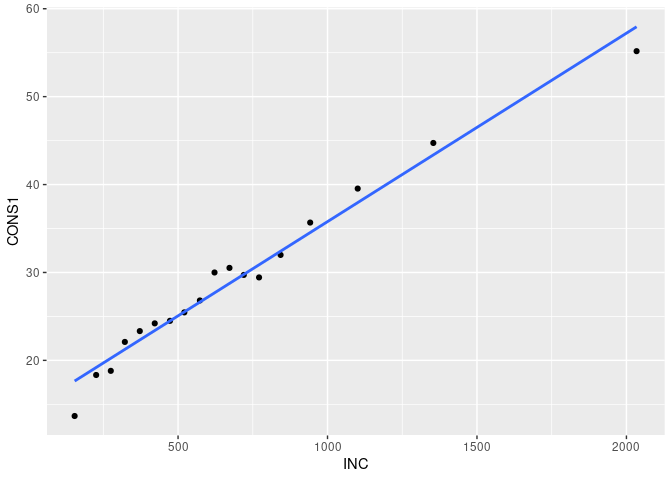

In [ ]:
ggplot(data = kakei) +
  aes(x = INC, 
      y = CONS1) +
  geom_point() +
  geom_smooth(method = "lm", 
              se     = FALSE)

### 回帰直線と平均

単回帰分析の場合回帰直線は必ずxとyの平均の交点を通る.

`geom_smooth()` using formula = 'y ~ x'

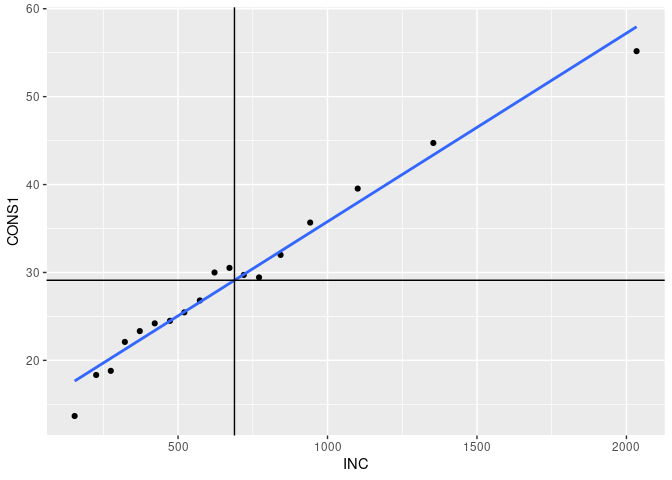

In [ ]:
ggplot(data = kakei) +
  aes(x = INC,
      y = CONS1) +
  geom_point() +
  geom_smooth(method = "lm", 
              se     = FALSE) +
  geom_vline(xintercept = mean(kakei$INC)) +
  geom_hline(yintercept = mean(kakei$CONS1))

### 決定係数と相関係数

単回帰分析の場合, 相関係数の2乗は決定係数と一致する.

In [ ]:
summary(ols1)$r.squared

[1] 0.9733384

[1] 0.9733384

[1] TRUE

## シミュレーションによる回帰分析のさらなる理解

### データの準備

ここからの演習ではシミュレーションデータを用いる.
母集団としてサイズが100万で平均2,
分散4の正規分布に従う説明変数を作成する. 応答変数は定数項が2,
説明変数の回帰係数が3, 誤差項は平均0で標準偏差1とする.

In [ ]:
pop <- with_seed(
  2718,
  data.frame(
    x = rnorm(n    = 1000000, 
              mean = 2, 
              sd   = 4)) |> 
    mutate(y = 2 + 3 * x + rnorm(n = 1000000)))

### 母集団のデータの概要

母集団のデータの概要を確認する.

In [ ]:
summary(pop)

       x                  y           
 Min.   :-16.9822   Min.   :-49.1780  
 1st Qu.: -0.6958   1st Qu.: -0.1162  
 Median :  1.9975   Median :  7.9842  
 Mean   :  1.9993   Mean   :  7.9982  
 3rd Qu.:  4.6972   3rd Qu.: 16.1196  
 Max.   : 23.2266   Max.   : 71.0073  

### 母集団の回帰係数

母集団を作成した際に利用した係数と推定された回帰係数は一致する.

In [ ]:
pop_lm <- lm(y ~ x, data = pop)
jtools::j_summ(pop_lm)

MODEL INFO:
Observations: 1000000
Dependent Variable: y
Type: OLS linear regression 

MODEL FIT:
F(1,999998) = 144324145.11, p = 0.00
R² = 0.99
Adj. R² = 0.99 

Standard errors:OLS
-------------------------------------------------
                    Est.   S.E.     t val.      p
----------------- ------ ------ ---------- ------
(Intercept)         2.00   0.00    1790.45   0.00
x                   3.00   0.00   12013.50   0.00
-------------------------------------------------

### モンテカルロ・シミュレーション

母集団からサイズ100の標本を1000個作成し, xの回帰係数を求める.

In [ ]:
p_load(broom)
sim_data <- with_seed(
  27182,
  map(1:1000, 
      \(x) slice_sample(pop, n = 100))) |>
  list_rbind(names_to = "number") |> 
  group_split(number) |> 
  map(\(data) lm(y ~ x, data = data)) |> 
  map(broom::tidy) |> 
  list_rbind()

### 回帰係数と不偏性

サンプル抽出を繰り返し, 回帰係数の期待値(平均)を取ると真の値と一致する.

In [ ]:
sim_data |>
  group_by(term) |> 
  summarise(mean(estimate))

# A tibble: 2 × 2
  term        `mean(estimate)`
  <chr>                  <dbl>
1 (Intercept)             1.99
2 x                       3.00

### 標本サイズを少しずつ増やす

サンプルサイズ10000に達するまで漸近的にサンプルサイズを増やしながら無作為抽出を行う.

In [ ]:
list2 <- 3:1000
sim_data2 <- with_seed(
  27182,
  list2 |> 
    map(\(size) slice_sample(pop, n = size))) |>
  list_rbind(names_to = "number") |> 
  group_split(number) |>
  map(\(data) lm(y ~ x, data = data)) |> 
  map(broom::tidy) |> 
  list_rbind(names_to = "number")

### 回帰係数と一致性

サンプルサイズが大きくなるにつれて標本の回帰係数は真の値に近づいていく.

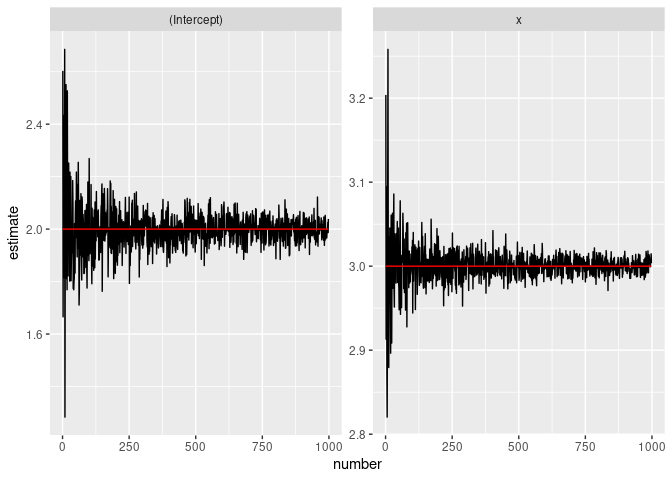

In [ ]:
sim_data2 |>
  mutate(
    true = if_else(term == "x",
                   3, 2)) |> 
  ggplot() +
  aes(x = number) +
  geom_line(aes(y = estimate)) +
  geom_line(aes(y = true),
            colour = "red") + 
  facet_wrap(~ term,
             scales = "free")